In [3]:
import pandas as pd
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'


Это домашнее задание по методу Ньютона. Дедлайн по отправке - 23:59 24 марта (воскресенье).

- Домашнее задание выполняется в этом же Jupyter Notebook'e. Можно использовать Google Colab, но прислать нужно выгруженный `.ipynb` ноутбук.

- В названии файла укажите свои фамилию и имя

- Решение каждой задачи/пункта задачи поместите после условия.

- В финальной версии, которая будет отправлена на проверку, должны быть удалены все отладочные артефакты. Под таким артефактами подразумеваются любые выводы ячеек, которые никак не прокоментированы в тексте, а также любой массовый/длинный технический вывод.

- При чистом перезапуске ноутбука (*Run -> Restart Kernel and Run All Cells* или *Kernel -> Restart & Run All* в юпитере) все ячейки должны выполняться без ошибок.

# Пуассоновская регрессия
## Формулировка задачи

Пожалуй, наиболее простой машинного обучения является линейная регрессия: 
    $$y_k \simeq \theta^\top x_k,$$ где $y_k \in \mathbb R$ - предсказываемая (зависимая) переменная, $x_k \in \mathbb R^d$ - вектор признаков (независимых переменных), $\theta \in \mathbb R^d$ - веса (коэффициенты, параметры) модели. Согласно теореме Гаусса-Маркова (в условиях её применимости) оптимальные веса определяются методом наименьших квадратов (МНК): $\sum_{k} (y_k - \theta^\top x_k)^2 \to \min\limits_\theta$


**1. (2)** К какому классу задач относится задача подбора весов линейной регрессии по методу МНК?

* $\nabla f(\theta) = \sum_k 2(y_k - \theta^Tx_k )*(-x_k)$

* $ \frac{\partial^2 f(\theta) }{\partial \theta_i \theta_j } = \frac{\partial}{\partial \theta_j} \sum_k 2(y_k - \theta^Tx_k )*(-x_k^i)  $


* $ \frac{\partial^2 f(\theta) }{\partial \theta_i \theta_j } = \sum_k [ 2 x^i_k x^j_k ] $

* $ \nabla^2 f(\theta) = \sum_k 2x_kx_k^T$

* $\nabla^2 f(\theta) = 2 X^TX$

* $\nabla^2 f(\theta) = 2 V D V^T$ , где $D = diag(\lambda_i)$ и $\lambda_i \ge 0$
* Но если предположить, что $X^TX$ невырождена, то $\lambda_i > 0$, например признаки независимы.
* В таком предположении задача $L = 2\max_i \lambda_i$ гладкая, и $\mu = 2\min_i \lambda_i$ сильно выпуклая 
* Заметим, что максимальное собственное число матрицы $X^TX$ - это спектральная норма матрицы $X$
* Но спектральная норма меньше фробениуса: $L \le 2\sum_k \| x_k\|^2$, но равенство может достичься, если все $x_k = x$, 

In [4]:
X = np.array([[1,17,7],[16,6,5],[3,9,13]])
X.T@X ==np.sum([np.outer(x, x) for x in X] , axis=0) # X^TX == \sum_k x_k^i x_k^j

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [5]:
Y = np.array([[1,2,3],[1,2,3],[1,2,3]])
U,D,VT = np.linalg.svd(Y.T@Y)
print(D[0]) # Спектральная норма        
print(np.sum(np.diag(Y.T@Y))) # Норма фробениуса

41.999999999999986
42


Линейная регрессия обычно применяется для предсказания непрерывных величин $y_k \in \mathbb R$. Для предсказания количества произошедших событий $y_k \in \mathbb N_+$ может использоваться пуассоновская регрессия
$$y_k \simeq  e^{\theta^\top x_k}.$$

В предположении, что $y_k$ имеют пуассоновское распределение, метод максимизации правдоподобия приводит к следующей задаче
$$f(\theta) = \sum_k \left(e^{x_k^\top \theta} - y_k \theta^\top x_k \right) \to \min_\theta$$


Будем решать задачу предсказания количества полученных студентом академических наград. Признаки - балл за экзамен по математике и программа обучения (категориальный признак с тремя значениями). Скачаем датасет (если `wget` не работает - скачайте вручную и положите в папку с ноутбуком) и посмотрим на содержимое

In [6]:
#  https://search.r-project.org/CRAN/refmans/gorica/html/academic_awards.html
!wget https://raw.githubusercontent.com/niquepolice/misc-files/master/StudentData.csv

--2024-03-31 22:41:06--  https://raw.githubusercontent.com/niquepolice/misc-files/master/StudentData.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 2116 (2,1K) [text/plain]
Сохранение в: ‘StudentData.csv.4’

StudentData.csv.4   100%[===================>]   2,07K  --.-KB/s    за 0s      

2024-03-31 22:41:06 (29,3 MB/s) - ‘StudentData.csv.4’ сохранён [2116/2116]



In [7]:
df = pd.read_csv("StudentData.csv")
df.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


Распределение числа наград (наш $y$) плюс-минус похоже на пуассоновское:

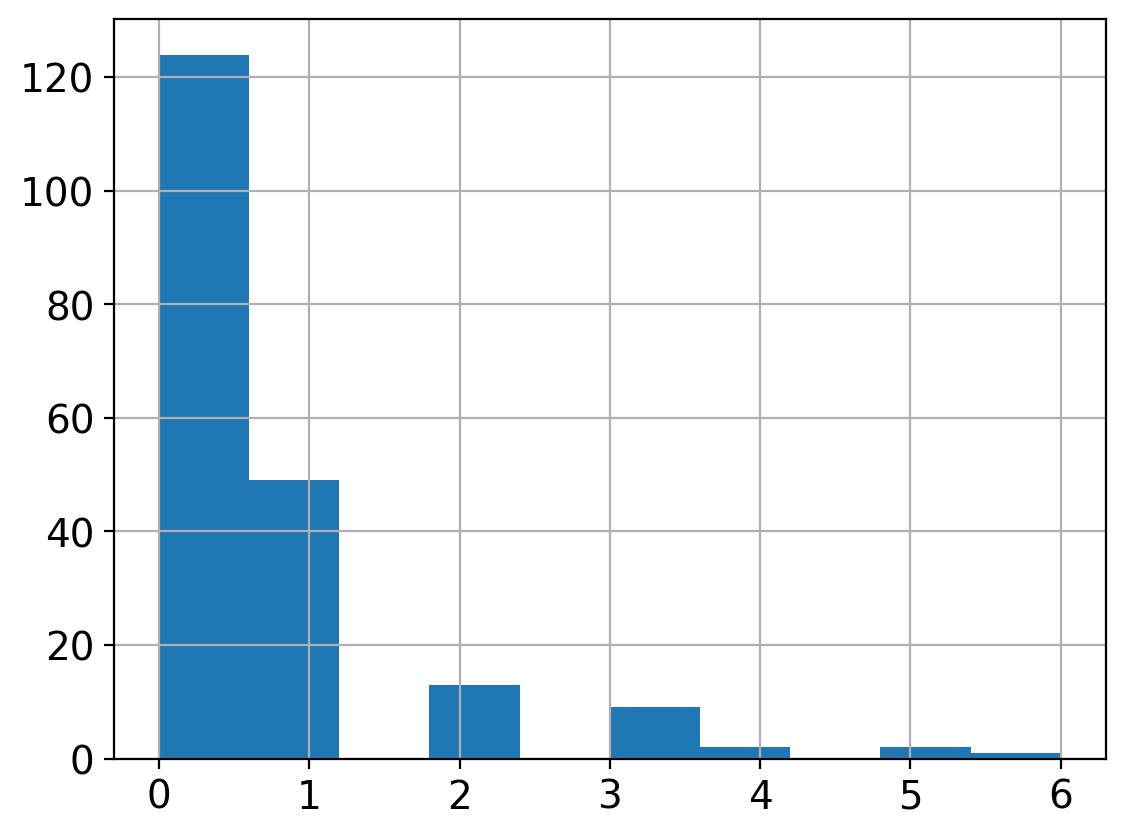

In [8]:
_ = df.num_awards.hist()

Категориальные признаки не имеют количественного смысла, поэтому разобьём переменную `prog` на три dummy-перменные (принимающие значения 0 или 1):

In [9]:
df_dummy = pd.get_dummies(df, columns=["prog"]) + 0  # cast booleans to integers
df_dummy

,id,num_awards,math,prog_1,prog_2,prog_3
0,45,0,41,0,0,1
1,108,0,41,1,0,0
2,15,0,44,0,0,1
3,67,0,42,0,0,1
4,153,0,40,0,0,1
...,...,...,...,...,...,...
195,100,2,71,0,1,0
196,143,2,75,0,0,1
197,68,1,71,0,1,0
198,57,0,72,0,1,0


## Решение через statsmodels

Конечно, существуют готовые имплементации пуассоновской регрессии. Для получения точного решения используем пакет `statsmodels`

In [10]:
import statsmodels.api as sm

# Сформируем вектор зависимых переменных и матрицу признаков
Y = df_dummy["num_awards"].values
# Добавим константный признак
X = sm.tools.add_constant(df_dummy[["math", "prog_1", "prog_2", "prog_3"]].values) 

fit_res = sm.Poisson(Y, X).fit()
fit_res.summary()

Optimization terminated successfully.
         Current function value: 0.913761
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 Mar 2024   Pseudo R-squ.:                  0.2118
Time:                        22:41:13   Log-Likelihood:                -182.75
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 3.747e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6882   8.09e+06  -4.56e-07      1.000   -1.59e+07    1.59e+07
x1             0.0702      0.011      6.619      0.000       0.049       0.091
x2            -1.5589   8.09e+06  -1.93e-07      1.000   -1.59e+07    1.59e+07
x3            -0.4751   8.09e+06  -5.87e-08      1.000   -1.59e+07    1.59e+07
x4            -1.1891   8.09e+06  -1.47e-07      1.000   -1.59e+07    1.59e+07
==============================================================================
"""

Сравним предсказания модели с правильными ответами

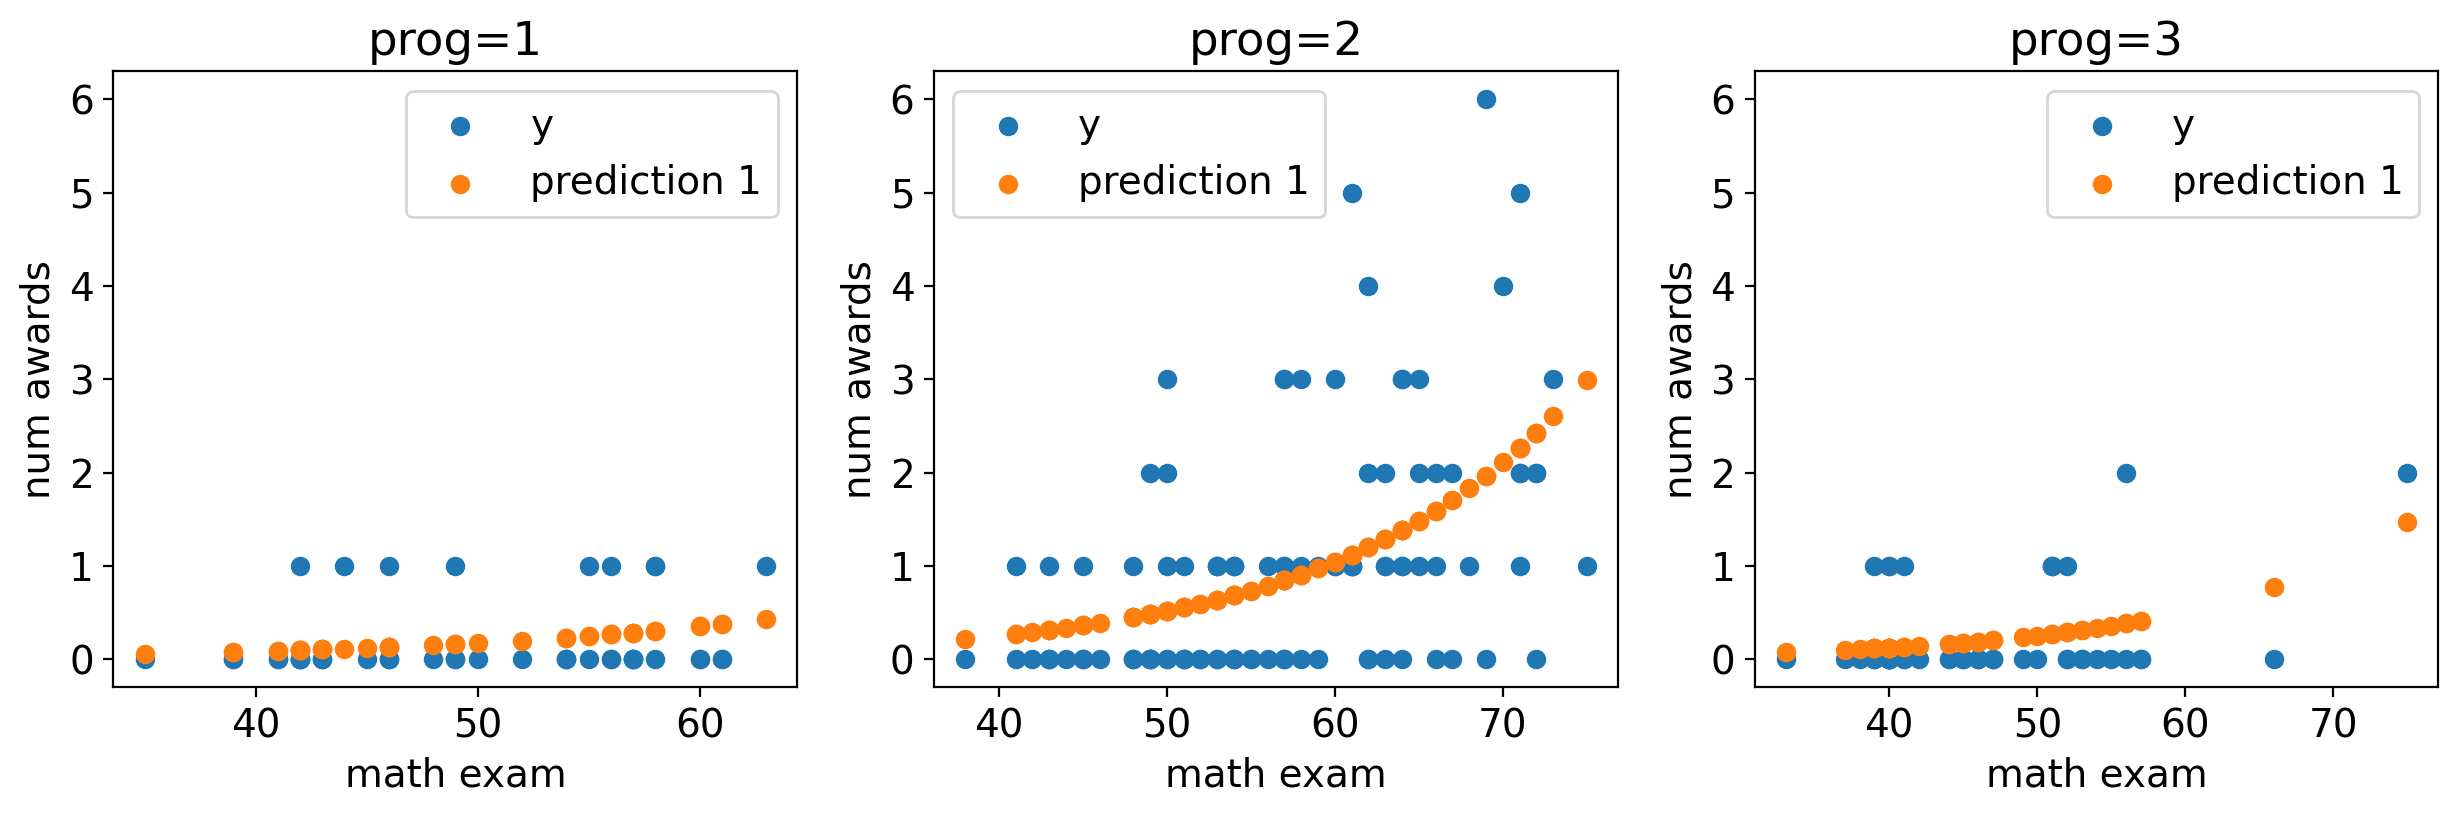

In [11]:
sm_pred = fit_res.predict(X)

def plot(*preds):
    plt.figure(figsize=(15, 4))
    ax = None
    for prog in [1, 2, 3]:
        ax = plt.subplot(130 + prog, sharey=ax)
        inds = df.prog == prog 
        plt.scatter(df.math[inds], Y[inds], label='y')
        for i, pred in enumerate(preds):
            plt.scatter(df.math[inds], pred[inds], label=f'prediction {i + 1}')
        plt.title(f"prog={prog}")
        plt.legend()
        plt.ylabel("num awards")
        plt.xlabel("math exam")
        
plot(sm_pred)

## Градиент

Обозначим через $X = \begin{pmatrix}x_1^\top \\ \vdots \\ x_n^\top \end{pmatrix}$ матрицу признаков, в строках которой лежат вектора признаков $x_k$ (переменная `X`, определённая в коде, имеет такую же структуру). Обозначим через $Y=\begin{pmatrix}y_1 \\ \vdots \\ y_n \end{pmatrix}$ вектор зависимых переменных. Тогда можем переписать целевую функцию (функцию потерь) $f$ в матрично-векторном виде (чтобы эффективно её вычислять с помощью `numpy` без питоновских циклов)
$$f(\theta) = \mathbf 1^\top \left(\exp(X\theta) - Y \odot X \theta \right),$$
где $\odot$ обозначает покомпонентное умножение, и функция $\exp$ тоже действует покомпонентно.

**2. (3)** Найдите градиент целевой функции $\nabla f(\theta)$ и запишите его **в матрично-векторном виде** в ячейке ниже. Имплементируйте вычисление целевой функции и градиента. Для вычисления градиента/гессиана по желанию можно использовать `jax`

* $ \nabla f(\theta ) = \exp(X\theta)^TX - Y \circ X $ 

* $df$/$d\theta_j = \sum( e^{x_k^T\theta}x_{kj} - y_kx_{kj}  ) => gradf=  X^T(e^{X\theta} - Y)  $

In [12]:
print(X.shape , Y.shape)

(200, 5) (200,)


In [13]:
# your сode
def f(theta: np.ndarray):
    return (np.exp(X @ theta) - Y * (X @ theta)).sum()
    
def gradf(theta: np.ndarray):
    return np.exp(X @ theta).T@X - Y @ X

theta = np.random.randn(X.shape[1])
d_theta = np.random.randn(X.shape[1])/1000

print(f(theta + d_theta ) - f(theta))
# print(gradf(theta))
print(gradf(theta)@d_theta)

-11.249584956598937
-11.249585073628996


**3. (5)** Ещё раз попробуем реализовать градиентный спуск, в самом простом варианте - с постоянным шагом.
$$\theta^{i+1} = \theta^i - h \nabla f(\theta^i).$$

- Реализуйте алгоритм, используя заготовку ниже. Постройте графики сходимости. Ниже есть ячейка, позволяющая визуально сравнить предсказания `statsmodels` и модели, полученной с помощью градиентного спуска

- Используя в качестве начальной точки $\theta^{0}$ вектор из нулей $\mathbf 0$, подберите максимальное значение длины шага $h$, при котором целевая функция $f(\theta^i)$ монотонно убывает. Ответ выведите в формате `f"{h:.0e}"`.


1) $df/d^2\theta_i\theta_j  = \sum e^{x_k^T\theta}x_{kj}x_{ki} = X^Tdiag(e^{X\theta})X   $

2) Да , $h^TX^Tdiag(e^{X\theta})Xh >= h^TX^TXh * min_k(e^{x_k^T\theta}) > 0$

Best possible loss value 135.10516063788072


Text(0.5, 0, 'Iter')

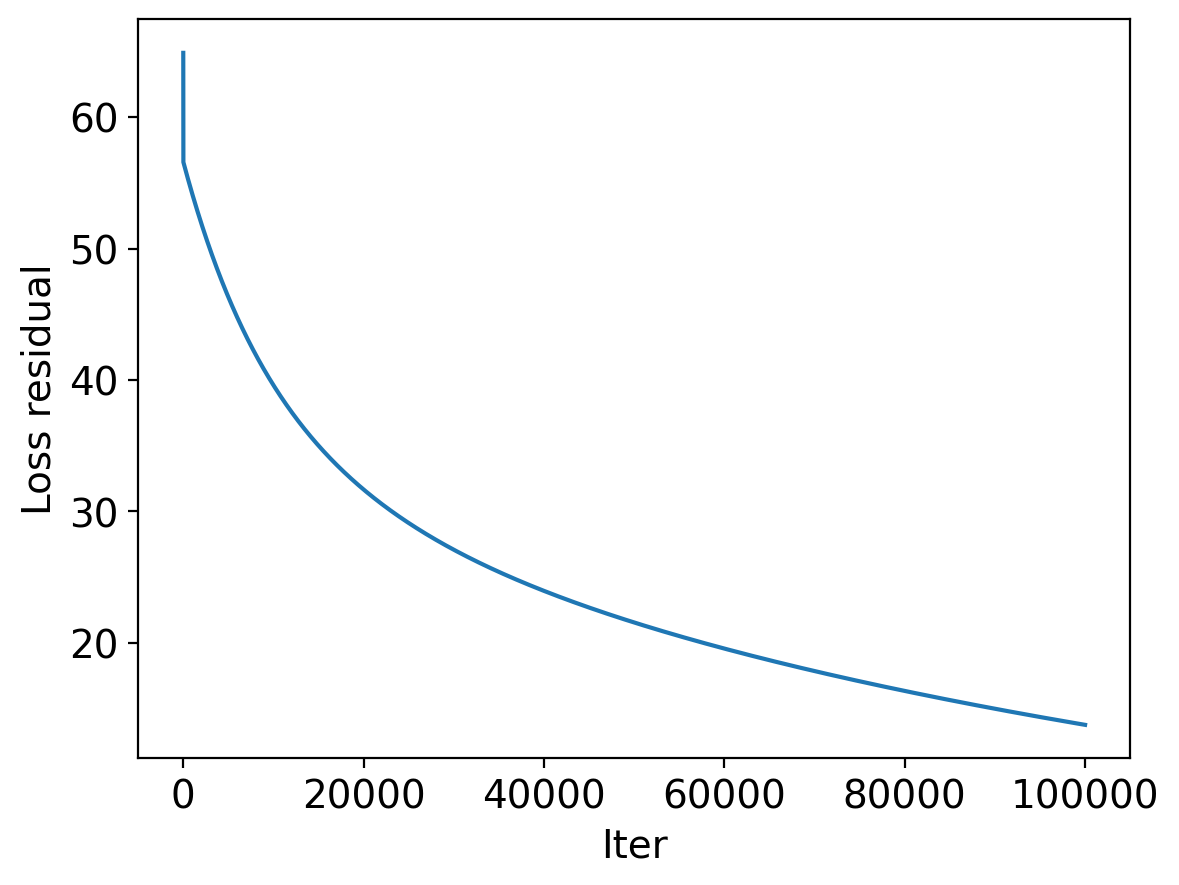

In [14]:
dim = X.shape[1] 
theta = np.zeros(dim)
fopt = (sm_pred - Y * np.log(sm_pred)).sum()  # optimal function value
print("Best possible loss value", fopt)

niters = 100000# ?
h = 1e-6
func_err = []
for i in range(niters):
    func_err.append(f(theta)-fopt)
    theta = theta - h*gradf(theta)
    
        
plt.plot(func_err)
plt.ylabel("Loss residual")
plt.xlabel("Iter")
# 


In [15]:
print(f"{h:.0e}")

1e-06


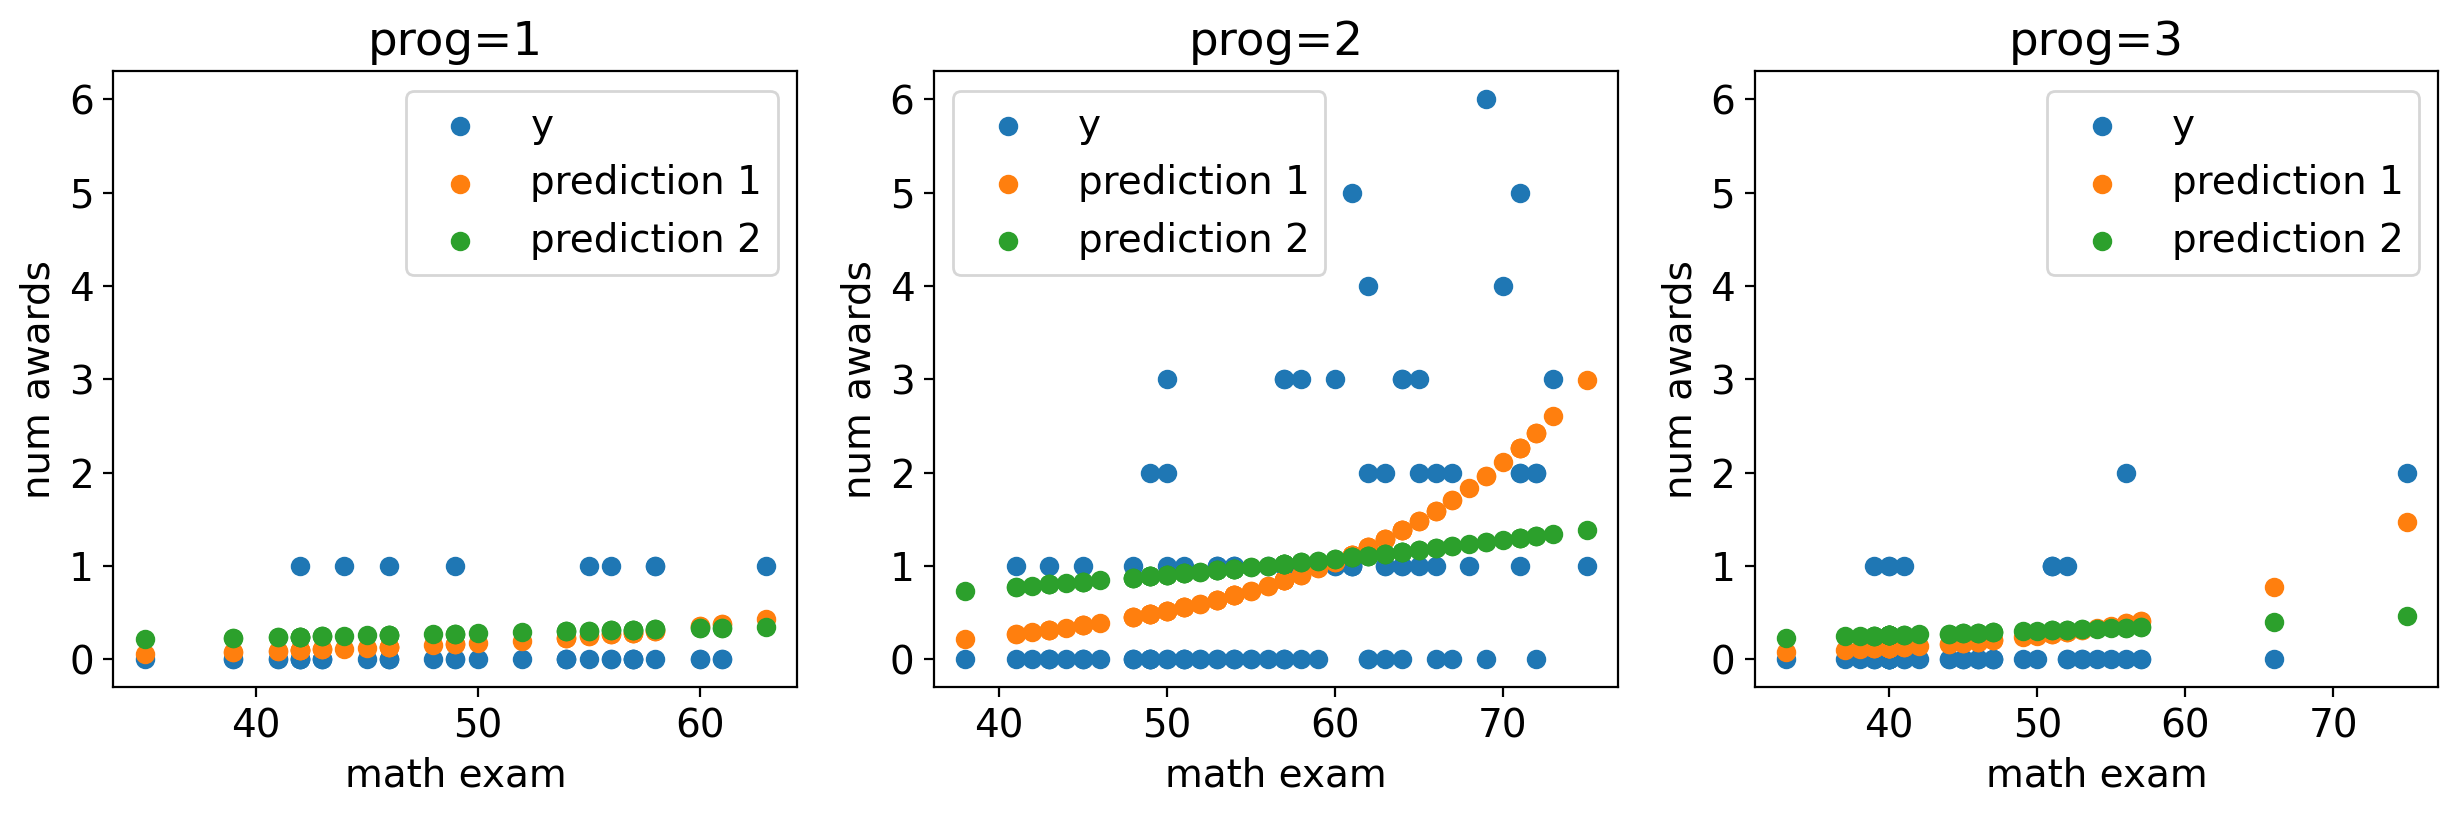

In [16]:
def predict(x, theta):
    return np.exp(x @ theta)

plot(sm_pred, predict(X, theta))

In [17]:
try:
    print(1+'as')
except:
    print(2)

2


## Метод Ньютона
**4. (3)** Найдите гессиан целевой функции $\nabla^2 f(\theta)$ и запишите его **в матрично-векторном виде** в ячейке ниже. Имплементируйте вычисление гессиана.


In [18]:
# Решение

1) $df/d^2\theta_i\theta_j  = \sum e^{x_k^T\theta}x_{kj}x_{ki} = X^Tdiag(e^{X\theta})X   $


In [19]:
# your code
def hessf(theta: np.ndarray):
    return np.transpose(X)@np.diag(np.exp(X@theta))@X

def hessf_2(theta: np.ndarray):
    return (np.diag(np.exp(X @ theta)) @ X).T @ X

print(hessf(theta) == hessf_2(theta))

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


Best possible loss value 135.10516063788072
Best achieved loss is 135.10516063788072


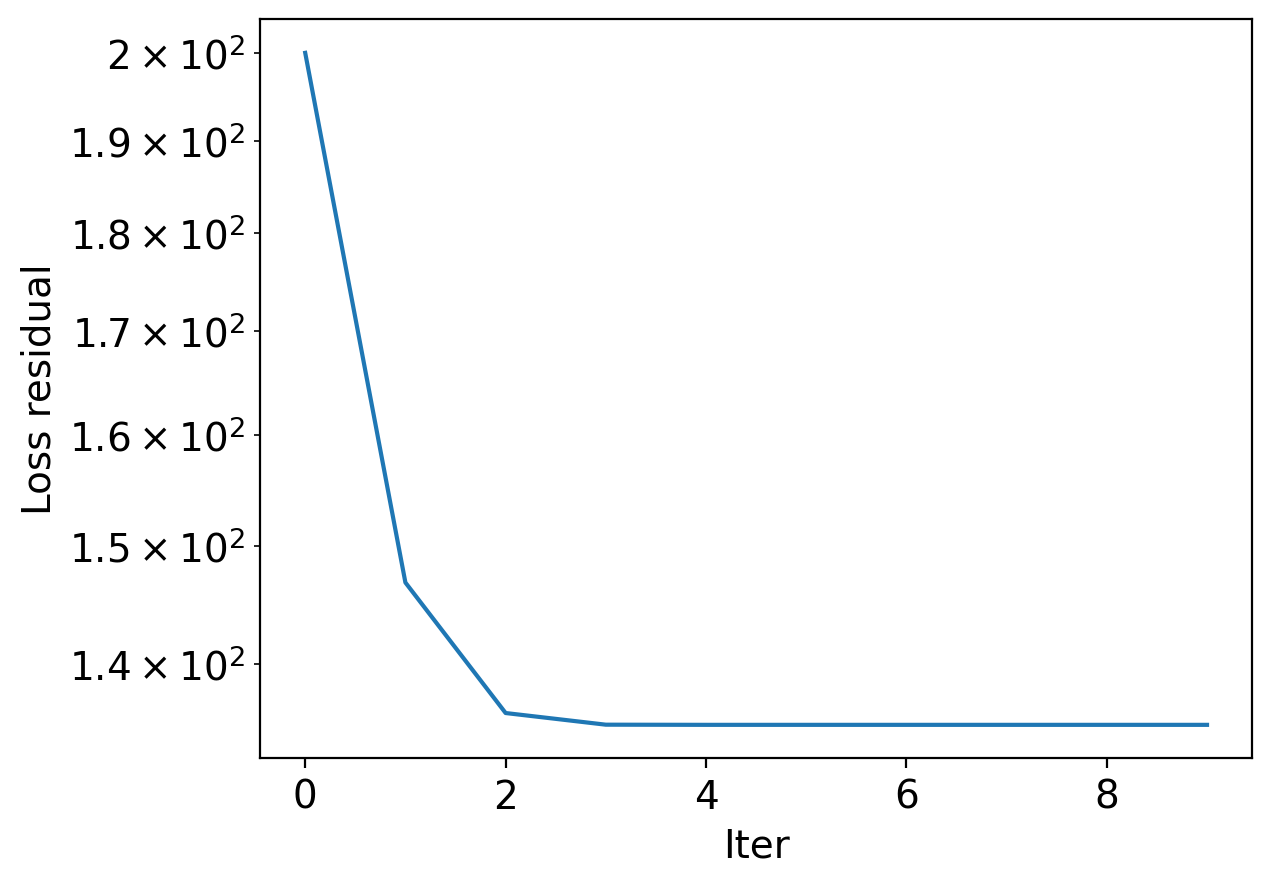

In [21]:
dim = X.shape[1]
theta = np.zeros(dim)
fopt = (sm_pred - Y * np.log(sm_pred)).sum()  # optimal function value
func_err = []
h = 1
grad = gradf(theta)
r = 0.9
a = 0.2
niter = 0
print(f(theta - h * grad), f(theta) - a*h*np.dot(grad, grad))
while(f(theta - h * grad) > f(theta) - a*h*np.dot(grad, grad)):
  loss = f(theta)
  func_err.append(loss)
  #step
  h *= r
  grad = gradf(theta)
  hessian = hessf(theta)
  reverse_hessian = np.linalg.inv(hessian)
  theta -= h * (reverse_hessian @ grad)
  niter += 1


print("Best achieved loss is", min(func_err))
plt.plot(np.arange(len(func_err)),func_err)
plt.ylabel("Loss residual")
plt.xlabel("Iter")
plt.yscale("log")
plt.show()

**5. (2)** Если $\text{ker } X = 0$, верно ли, что гессиан положительно определен: $\nabla^2 f(\theta) \succ 0$ ?


2) Да , $h^TX^Tdiag(e^{X\theta})Xh >= h^TX^TXh * min_k(e^{x_k^T\theta}) > 0$

* Xh != 0 при h !=0 , а h^TX^TXh  -- это норма этого вектора, которая > 0

In [ ]:
# Решение

**6. (5)** 
- Имплементируйте классический метод Ньютона для решения задачи пуассоновской регрессии. Для обращения гессиана пригодится пакет `np.linalg`. Постройте графики сходимости.
$$\theta^{k+1} = \theta^{k} - [\nabla^2 f(\theta^k)]^{-1} \nabla f(\theta^k)$$
- Опишите поведение алгоритма на нашей задаче. Попробуйте разные начальные точки $\theta^0$.



0.0012498445454411922


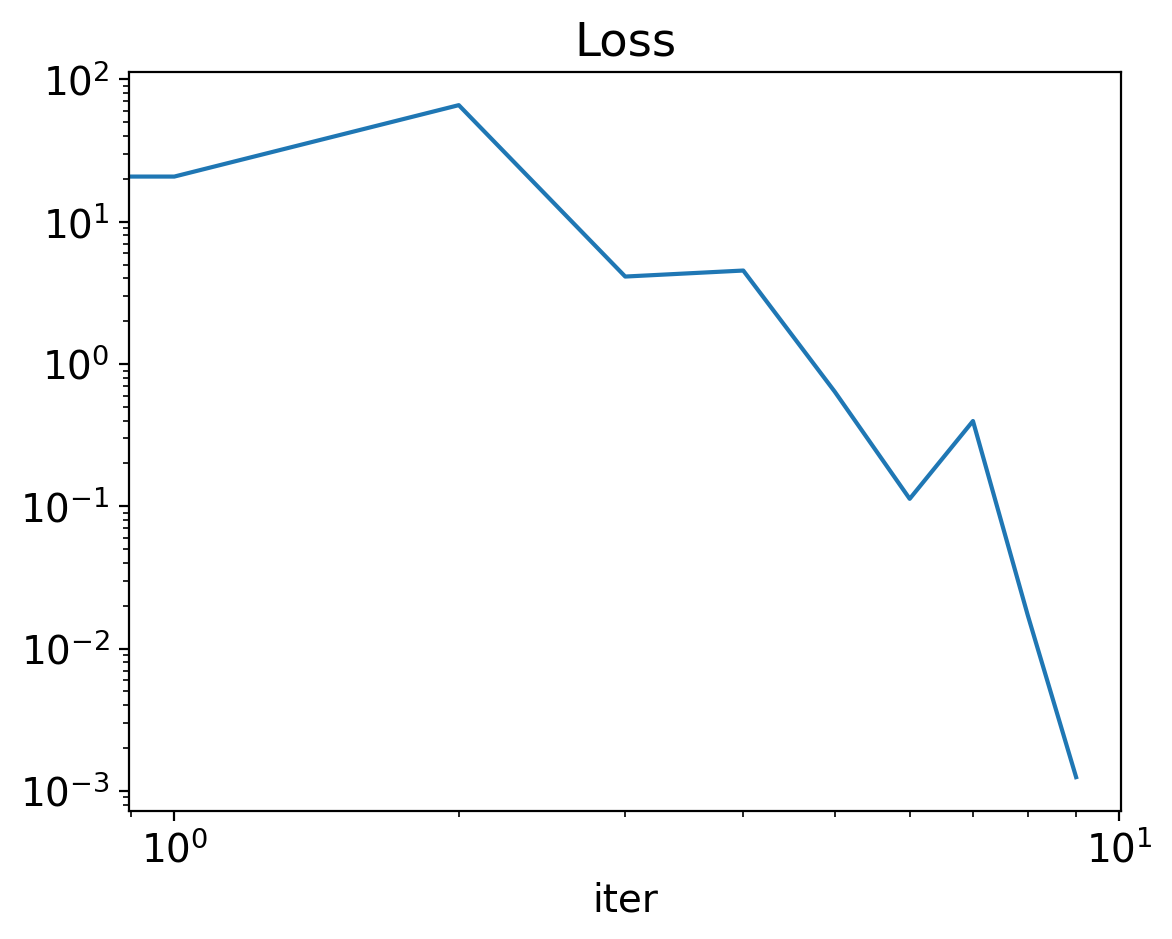

In [70]:
dim = X.shape[1] 
theta = np.zeros(dim)
# theta =  np.zeros(dim)

niters = 10 # ?
flog = []
for i in range(niters):
    flog.append(f(theta)-fopt)
    theta = theta - np.linalg.inv(hessf(theta))@gradf(theta)
print(flog[-1])
    
plt.loglog(flog)
plt.title("Loss")
plt.xlabel("iter")
plt.show()

In [ ]:
# conclusions 

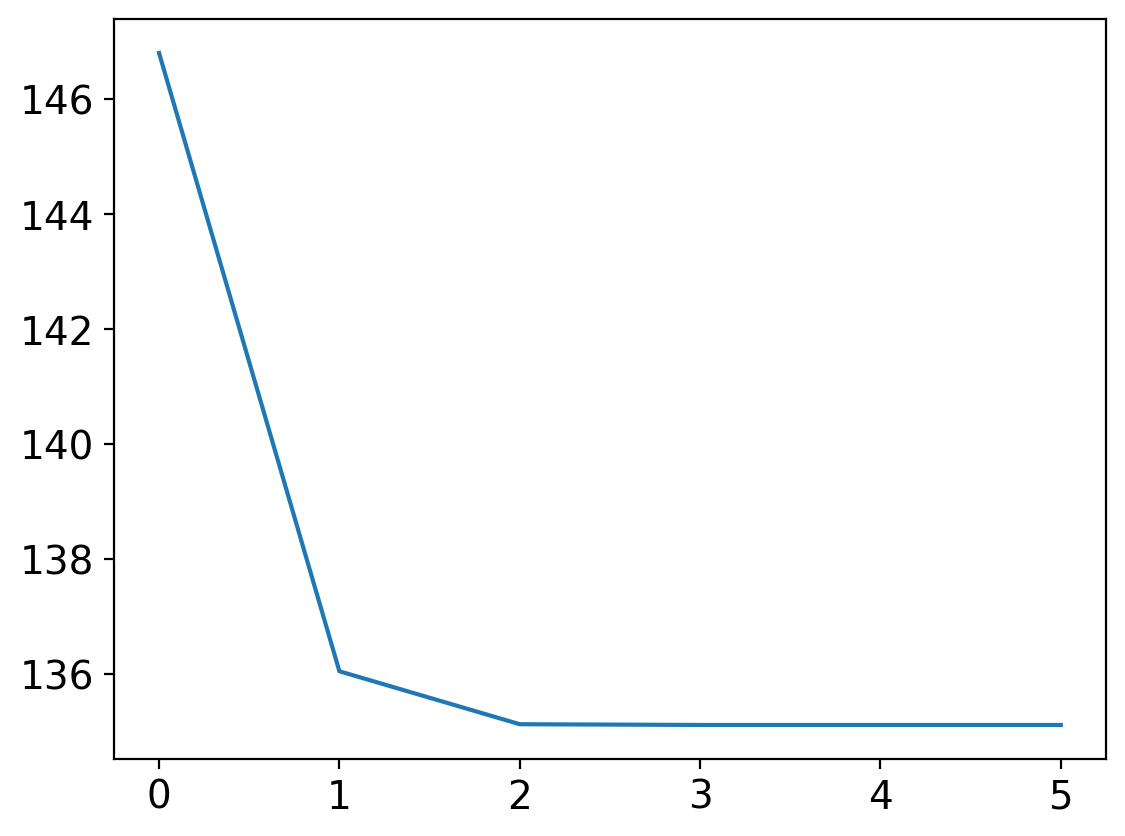

In [25]:
def damped_newton_method(theta_init, max_iters=100, tolerance=1e-5, alpha=0.3, rho=0.8):
    theta = theta_init
    theta_history = [theta.copy()]
    h_k = 1

    for k in range(max_iters):
        grad = gradf(theta)
        hess = hessf(theta)
        # delta = np.linalg.solve(hess, grad)
        delta = np.linalg.pinv(hess)@grad
        g_k = delta

        # Правило Армихо для подбора шага
        while f(theta - h_k * g_k) > f(theta) - alpha * h_k * np.dot(grad, g_k):
            h_k *= rho

        # Обновление theta
        theta -= h_k * g_k
        theta_history.append(f(theta))

        # Проверка на сходимость
        if np.linalg.norm(g_k) * h_k < tolerance:
            break

    return theta, theta_history

theta_init = np.zeros(dim)
theta, theta_history = damped_newton_method(theta_init, max_iters=100, tolerance=1e-5, alpha=0.3, rho=0.8)
plt.plot(theta_history[1:])

In [56]:
X.T @ (X * (np.exp(X@theta)*np.ones((5,1))))

ValueError: operands could not be broadcast together with shapes (200,5) (5,200) 

In [32]:
U,d,v = np.linalg.svd(hessf(theta))
d

array([4.69980823e+05, 2.38767731e+01, 1.01958275e+01, 3.52900447e+00,
       2.66376694e-13])

In [72]:
def Newton(theta):
  niters = 10 # ?
  func_err = []
  for i in range(niters):
    func_err.append(f(theta))
    theta = theta - np.linalg.inv(hessf(theta)) @ gradf(theta)

  plt.plot(func_err)
  plt.ylabel("Loss residual")
  plt.xlabel("Iter")
  return theta

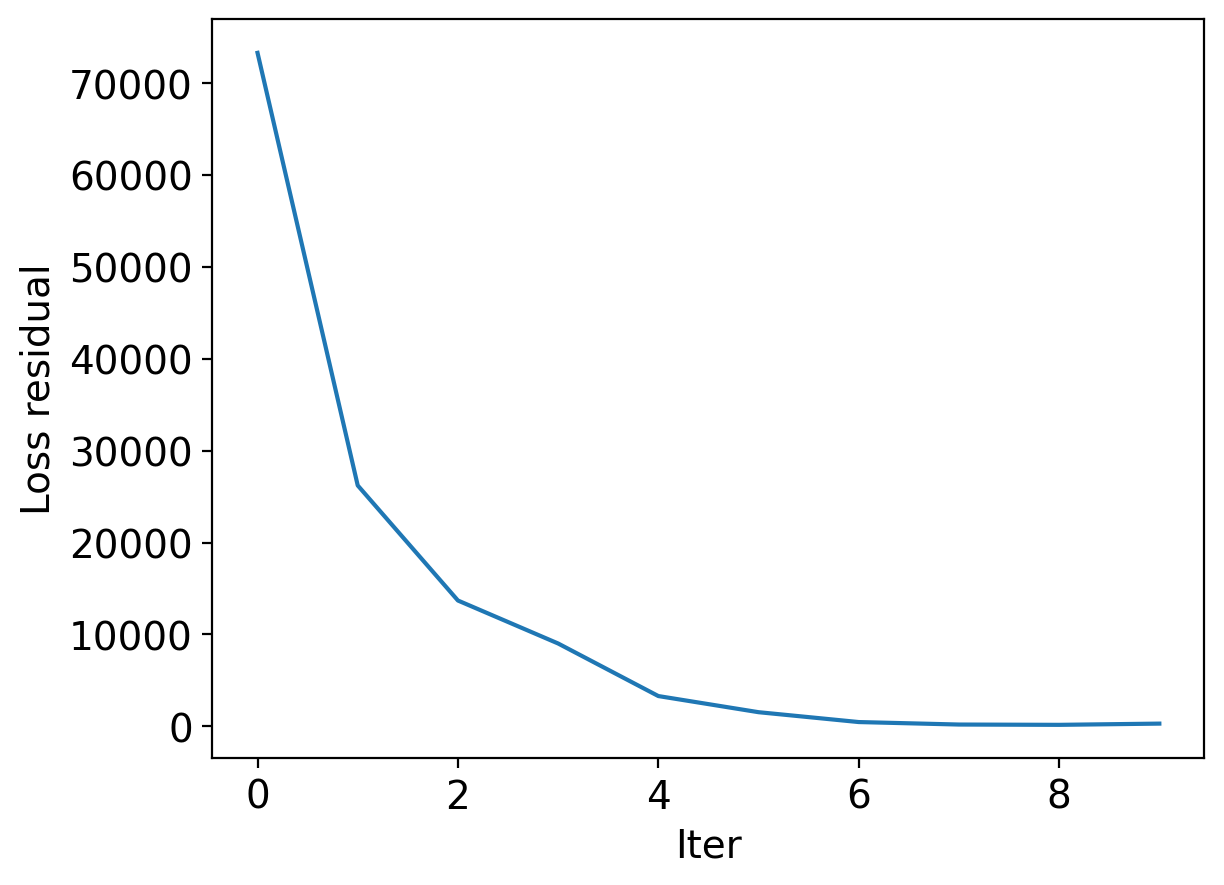

In [73]:
dim = X.shape[1]
theta = np.ones(dim) / 10
ans = Newton(theta)

/tmp/ipykernel_627351/1436897228.py:3: RuntimeWarning: overflow encountered in exp
  return (np.exp(X @ theta) - Y * (X @ theta)).sum()
/tmp/ipykernel_627351/1620748823.py:3: RuntimeWarning: invalid value encountered in matmul
  return np.transpose(X)@np.diag(np.exp(X@theta))@X
/tmp/ipykernel_627351/1436897228.py:6: RuntimeWarning: overflow encountered in exp
  return np.exp(X @ theta).T@X - Y @ X
/tmp/ipykernel_627351/1436897228.py:6: RuntimeWarning: invalid value encountered in matmul
  return np.exp(X @ theta).T@X - Y @ X


array([nan, nan, nan, nan, nan])

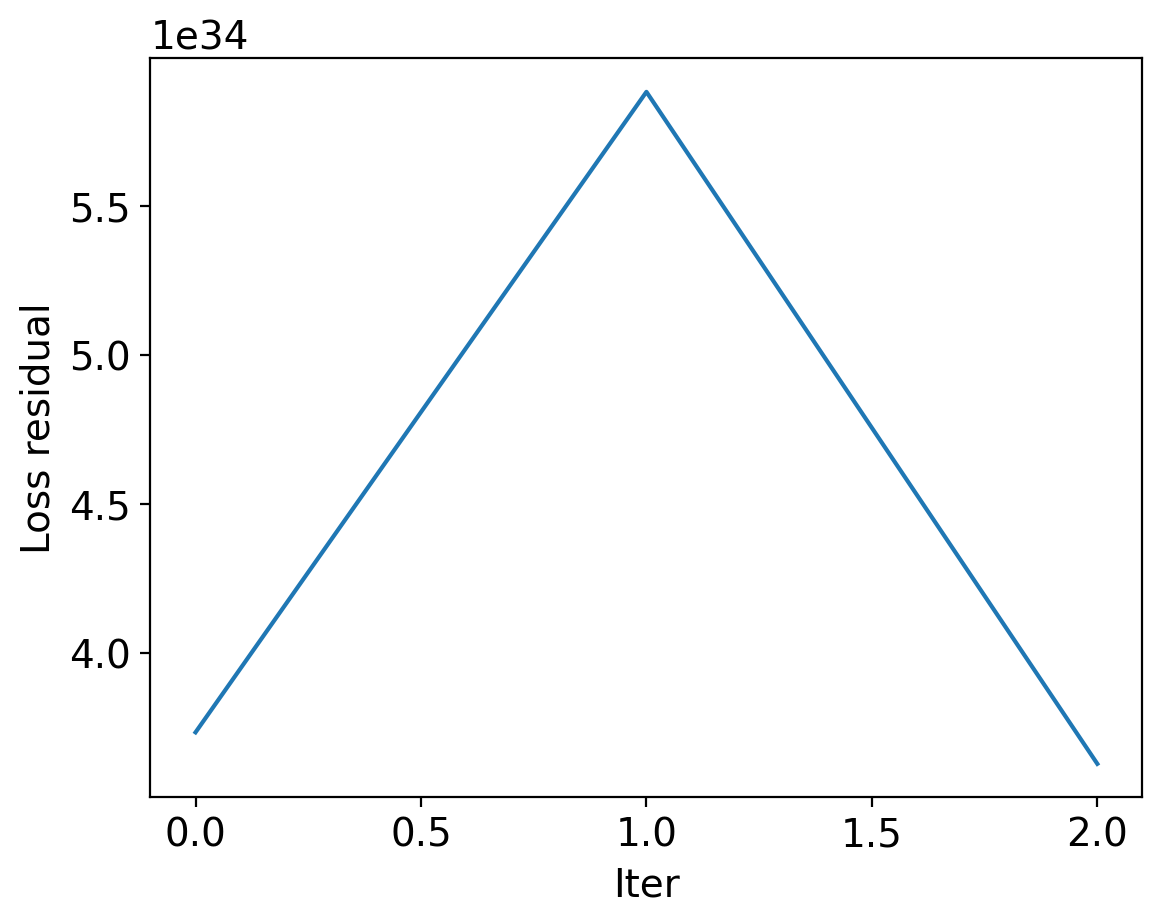

In [75]:
theta = np.array([3, 1, 1, 0.5, 1]).astype(float)
Newton(theta)

### Демпфированный метод Ньютона


$$\theta^{k+1} = \theta^{k} - \color{red}{h^k} [\nabla^2 f(\theta^k)]^{-1} \nabla f(\theta^k)$$

Воспользуйтесь правилом Армихо для выбора шага (по желанию можно вместо него реализовать правило Вульфа):
- $\theta^{k+1} = \theta^k - h^k g^k,$
- Пока $f(\theta^k - h^k g^k) > f(\theta^k) - \alpha h^k \langle g^k, \nabla f(\theta^k) \rangle$ уменьшать шаг: $h^k = h^k \cdot \rho$.

Здесь $\alpha \geq 0$ and $0 < \rho < 1$ - гиперпараметры. Обычно $\alpha \leq 0.3$.


**7. (6)**
- Покажите, что правило Армихо корректно определено для гладких функций $f$, т.е. цикл подбора длины шага остановится за конечное число итераций, подобрав $h^k > 0$.

- Реализуйте демпфированный метод Ньютона. Насколько выше (грубо/качественно) арифметическая сложность одной его итерации по сравнению с классическим методом Ньютона?

Best possible loss value 135.10516063788072
Achieved value: 199.999212832509


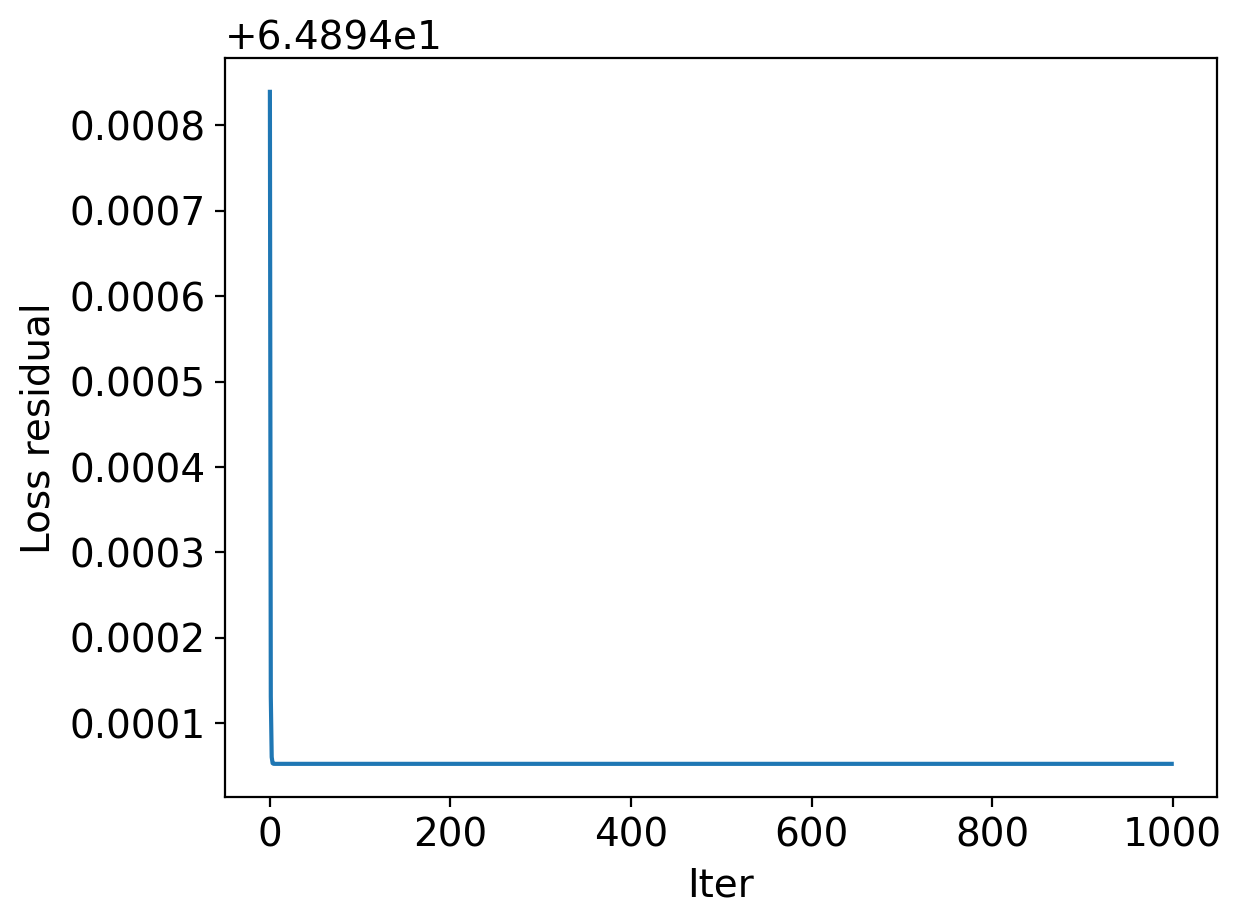

In [71]:
dim = X.shape[1] 
theta = np.zeros(dim)
fopt = (sm_pred - Y * np.log(sm_pred)).sum()  # optimal function value
print("Best possible loss value", fopt)

niters = 10**3
h = 4e-06
r = 0.1
alpha = 0.1

func_err = []
for i in range(niters):
    func_err.append(np.abs(fopt-f(theta)))
    try:
        theta -= h * (np.linalg.pinv(hessf(theta)) @ gradf(theta))  
    except Exception as e:
        break
    theta -= h * (np.linalg.pinv(hessf(theta)) @ gradf(theta))
    if (f(theta - h * gradf(theta)/len(gradf(theta)) > f(theta) - alpha * h * np.linalg.norm(gradf(theta)))):
        h *= r
    else:
        break

plt.plot(func_err)
plt.ylabel("Loss residual")
plt.xlabel("Iter")

print(f'Achieved value: {f(theta)}') 

In [67]:
func_err[-1]

64.89391148743982

/tmp/ipykernel_550207/1436897228.py:3: RuntimeWarning: overflow encountered in exp
  return (np.exp(X @ theta) - Y * (X @ theta)).sum()


-5.684341886080802e-14


Text(0.5, 0, 'iter')

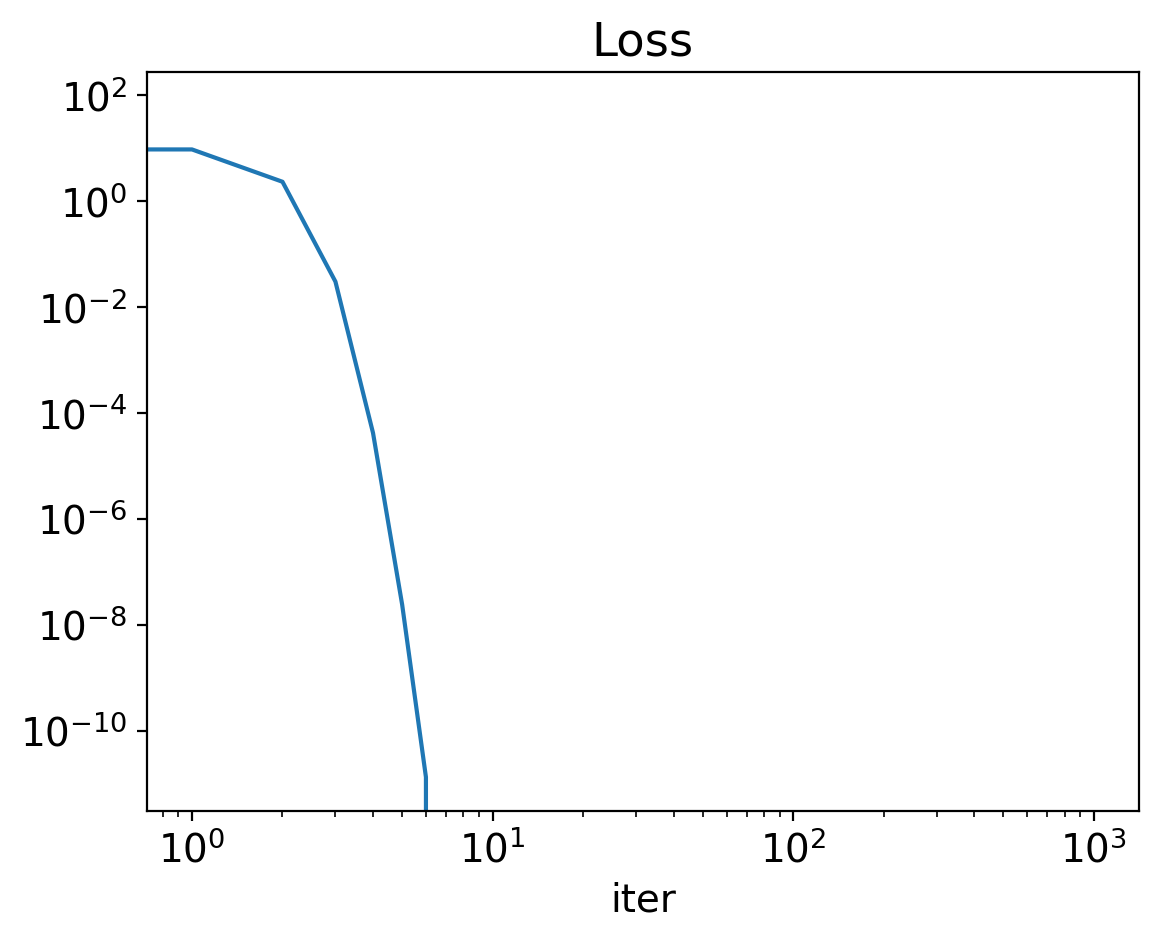

In [68]:
# Решение
dim = X.shape[1] 
theta = np.zeros(dim)
h = 1e3
a = 0.2
p = 0.5
niters = 10**3 # ?
flog = []
cnts = []
for i in range(niters):
    flog.append(f(theta) - fopt)
    g = np.linalg.pinv(hessf(theta))@gradf(theta)
    cnt = 1
    while f(theta - h*g) > f(theta) - a*h*np.dot(g,gradf(theta)) :
        cnt +=1
        h = h*p
    cnts.append(cnt)
    theta = theta - h*g

print(flog[-1])
    
plt.loglog(flog)
plt.title("Loss")
plt.xlabel("iter")

In [42]:
np.mean(cnts)

1.15

**8\*. (8\*)** Вычислительное ускорение

- Предложите способ вычислять направление шага $g^k$ с арифметической сложностью $O(d^2)$ (матрица $X \in \mathbb R^{O(d) \times O(d)}$). То есть расскажите, как сделать так, чтобы препроцессинг/первая итерация алгоритма стоила $O(d^3)$, a все последующие - $O(d^2)$.
- Имплементируйте, замерьте время

In [ ]:
# Решение